In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt


from scipy.stats import t, norm
from scipy.linalg import cholesky
from scipy.optimize import brentq

# Problem 1

In [2]:
df_problem_1 = pd.read_csv('DailyPrices.csv')[['SPY', 'AAPL', 'EQIX']]
df_problem_1.head(3)

,SPY,AAPL,EQIX
0,370.367920,123.768456,639.647766
1,373.227142,125.045052,656.679016
2,368.967438,123.718987,637.822998


## 1A.

In [3]:
df_arithmetic_return = pd.DataFrame()
for stock in df_problem_1.columns:
    arithmetic_return = df_problem_1[stock].pct_change().iloc[1:]
    arithmetic_return_0_mean = arithmetic_return - np.mean(arithmetic_return)
    df_arithmetic_return[stock] = arithmetic_return_0_mean

print('last 5 rows:')
print(df_arithmetic_return.tail(5))
print('\n')
print('total standard deviation:')
print(df_arithmetic_return.std())


last 5 rows:
          SPY      AAPL      EQIX
499 -0.011492 -0.014678 -0.006966
500 -0.012377 -0.014699 -0.008064
501 -0.004603 -0.008493  0.006512
502 -0.003422 -0.027671  0.000497
503  0.011538 -0.003445  0.015745


total standard deviation:
SPY     0.008077
AAPL    0.013483
EQIX    0.015361
dtype: float64


## 1B.

In [4]:
df_log_return = pd.DataFrame()
for stock in df_problem_1.columns:
    log_return = np.log((df_problem_1[stock]/df_problem_1[stock].shift(1)).iloc[1:])
    log_return_0_mean = log_return - np.mean(log_return)
    df_log_return[stock] = log_return_0_mean

print('last 5 rows:')
print(df_log_return.tail(5))
print('\n')
print('total standard deviation:')
print(df_log_return.std())

last 5 rows:
          SPY      AAPL      EQIX
499 -0.011515 -0.014675 -0.006867
500 -0.012410 -0.014696 -0.007972
501 -0.004577 -0.008427  0.006602
502 -0.003392 -0.027930  0.000613
503  0.011494 -0.003356  0.015725


total standard deviation:
SPY     0.008078
AAPL    0.013446
EQIX    0.015270
dtype: float64


# Problem 2

In [5]:
df_problem_2 = pd.read_csv('DailyPrices.csv')[['Date', 'SPY', 'AAPL', 'EQIX']]
df_problem_2 = df_problem_2.set_index('Date')
df_problem_2.head(3)

,SPY,AAPL,EQIX
Date,,,
2023-01-03,370.367920,123.768456,639.647766
2023-01-04,373.227142,125.045052,656.679016
2023-01-05,368.967438,123.718987,637.822998


## 2A.

In [6]:
# Portfolio holdings
holdings = {
    'SPY': 100,
    'AAPL': 200,
    'EQIX': 150
}
df_latest = df_problem_2.loc['2025-01-03']
# Calculate portfolio value
current_value = sum(holdings[stock] * price for stock, price in zip(holdings.keys(), df_latest))

print(f'portfolio value at 1/3/2025: {current_value:.4f}')

portfolio value at 1/3/2025: 251862.4969


## 2B.

In [ ]:
df = pd.read_csv('DailyPrices.csv')

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)


positions = {'SPY': 100, 'AAPL': 200, 'EQIX': 150}


current_date = pd.Timestamp('2025-01-03')
current_prices = df.loc[current_date, ['SPY', 'AAPL', 'EQIX']]



portfolio_value = sum(positions[sym] * current_prices[sym] for sym in positions)
print("current price at 2025-01-03: ${:,.2f}".format(portfolio_value))



returns = df[['SPY', 'AAPL', 'EQIX']].pct_change().dropna()
# select data before 2025-01-03 to estimate
returns = returns.loc[:(current_date - pd.Timedelta(days=1))]
returns = returns - returns.mean()


\current price at 2025-01-03: $251,862.50


In [8]:
lambda_ = .97
def populate_weights(n: int, lambda_factor: float):
    """calculate exponential weights

    Args:
        n (int): length of data
        lambda_factor (float): decay factor λ between 0 an 1

    Returns:
        _type_: weight array, cumulative weight array
    """
    w = np.zeros(n)  
    cumulative_w = np.zeros(n)  
    total_w = 0.0  

    for i in range(n):
        w[i] = (1 - lambda_factor) * lambda_factor ** (i + 1)
        total_w += w[i]
        cumulative_w[i] = total_w

    w /= total_w
    cumulative_w /= total_w

    return w, cumulative_w


def exponentially_weighted_covariance_matrix(df: pd.DataFrame, lambda_factor: float):
    """calculate exponentially weighted covariance matrix

    Args:
        df (pd.DataFrame): 
        lambda_factor (float): decay factor λ between 0 an 1

    Returns:
        _type_: exponentially weighted covariance matrix
    """
    n = len(df)  
    weights, _ = populate_weights(n, lambda_factor)  
    weights = weights[::-1]  
    df = df.loc[:, df.columns != "Date"]
    means = (df.T * weights).sum(axis=1)  
    
    mean_centered = df - means  

    variables = df.columns
    cov_matrix = pd.DataFrame(index = variables, columns = variables, dtype = float)

    for i in variables:
        for j in variables:
            cov_matrix.loc[i, j] = np.sum(weights * mean_centered[i] * mean_centered[j])

    return cov_matrix
exponentially_weighted_covariance_matrix(returns[['SPY']], .97)['SPY'].values[0]

6.946182603773344e-05

In [9]:
# a: Normally distributed with exponentially weighted covariance with lambda=0.97:

lambda_ = 0.97
ewma_sigma = {}

for asset in ['SPY', 'AAPL', 'EQIX']:
    asset_ewm_var = exponentially_weighted_covariance_matrix(returns[[asset]], .97)[asset].values[0]
    ewma_sigma[asset] = np.sqrt(asset_ewm_var)


def normal_var_es(sigma, alpha_level=0.05):

    z = norm.ppf(alpha_level)
    var = - z * sigma
    # ES = sigma * [phi(z) / alpha_level]
    es = sigma * (norm.pdf(z) / alpha_level)
    return var, es

var_es_a = {}
for sym in positions:
    current_value = positions[sym] * current_prices[sym]
    var_pct, es_pct = normal_var_es(ewma_sigma[sym])
    var_es_a[sym] = {'VaR': current_value * var_pct,
                     'ES':  current_value * es_pct}
    
cov_matrix = exponentially_weighted_covariance_matrix(returns, .97).values
V = np.array([positions[sym] * current_prices[sym] for sym in ['SPY', 'AAPL', 'EQIX']])
portfolio_variance = np.dot(V, np.dot(cov_matrix, V))
portfolio_sigma = np.sqrt(portfolio_variance)
var_port_a, es_port_a = normal_var_es(portfolio_sigma)

var_es_a['Portfolio'] = {'VaR': var_port_a, 'ES': es_port_a}

print("\na: Normally distributed with exponentially weighted covariance with lambda=0.97:")
for key, value in var_es_a.items():
    print("{}: VaR = ${:,.2f}, ES = ${:,.2f}".format(key, value['VaR'], value['ES']))



a: Normally distributed with exponentially weighted covariance with lambda=0.97:
SPY: VaR = $811.49, ES = $1,017.65
AAPL: VaR = $958.43, ES = $1,201.91
EQIX: VaR = $2,905.43, ES = $3,643.52
Portfolio: VaR = $3,829.45, ES = $4,802.28


In [ ]:
# b. T distribution using a Gaussian Copula

nu = 4  
N_sim = 100000  

sample_std = returns.std()

# T ~ t(df, scale), var = scale^2 * nu/(nu-2) (nu>2)
# scale = sample_std * sqrt((nu-2)/nu)
scale = sample_std * np.sqrt((nu - 2) / nu)

corr_matrix = returns[['SPY', 'AAPL', 'EQIX']].corr()


mean = np.zeros(3)
sim_norm = np.random.multivariate_normal(mean, corr_matrix, size=N_sim)
sim_uniform = norm.cdf(sim_norm)
sim_t = np.empty_like(sim_uniform)
for i, sym in enumerate(['SPY', 'AAPL', 'EQIX']):
    sim_t[:, i] = t.ppf(sim_uniform[:, i], df=nu) * scale[sym]


simulated_dollar_returns = {}
var_es_b = {}

for i, sym in enumerate(['SPY', 'AAPL', 'EQIX']):
    current_val = positions[sym] * current_prices[sym]

    dollar_returns = current_val * sim_t[:, i]
    simulated_dollar_returns[sym] = dollar_returns
    # VaR
    var_val = - np.percentile(dollar_returns, 5)
    # ES
    es_val = - dollar_returns[dollar_returns <= np.percentile(dollar_returns, 5)].mean()
    var_es_b[sym] = {'VaR': var_val, 'ES': es_val}

# porfolio:
portfolio_simulated_returns = np.sum(
    np.column_stack([simulated_dollar_returns[sym] for sym in ['SPY', 'AAPL', 'EQIX']]),
    axis=1
)
var_port_b = - np.percentile(portfolio_simulated_returns, 5)
es_port_b = - portfolio_simulated_returns[portfolio_simulated_returns <= np.percentile(portfolio_simulated_returns, 5)].mean()
var_es_b['Portfolio'] = {'VaR': var_port_b, 'ES': es_port_b}

print("\nb. T distribution using a Gaussian Copula")
for key, value in var_es_b.items():
    print("{}: VaR = ${:,.2f}, ES = ${:,.2f}".format(key, value['VaR'], value['ES']))



b. T distribution using a Gaussian Copula
SPY: VaR = $719.85, ES = $1,076.86
AAPL: VaR = $989.02, ES = $1,489.89
EQIX: VaR = $3,330.41, ES = $5,056.67
Portfolio: VaR = $4,274.21, ES = $6,239.29


In [11]:
# c. Historic simulation using the full history.

var_es_c = {}

for sym in ['SPY', 'AAPL', 'EQIX']:
    current_val = positions[sym] * current_prices[sym]
    var_val_return = - np.percentile(returns[sym], 5)
    es_val_return = - returns[sym][returns[sym] <= np.percentile(returns[sym], 5)].mean()
    var_val = var_val_return * current_val
    es_val = es_val_return * current_val
    var_es_c[sym] = {'VaR': var_val, 'ES': es_val}

# portfolio
portfolio_dollar_returns = (positions['SPY'] * current_prices['SPY'] * returns['SPY'] +
                            positions['AAPL'] * current_prices['AAPL'] * returns['AAPL'] +
                            positions['EQIX'] * current_prices['EQIX'] * returns['EQIX']).values
var_port_c = - np.percentile(portfolio_dollar_returns, 5)
es_port_c = - portfolio_dollar_returns[portfolio_dollar_returns <= np.percentile(portfolio_dollar_returns, 5)].mean()
var_es_c['Portfolio'] = {'VaR': var_port_c, 'ES': es_port_c}

print("\nc. Historic simulation using the full history: ")
for key, value in var_es_c.items():
    print(f"{key}: VaR = ${value['VaR']:,.2f}, ES = ${value['ES']:,.2f}")



c. Historic simulation using the full history: 
SPY: VaR = $871.06, ES = $1,078.74
AAPL: VaR = $1,068.56, ES = $1,438.12
EQIX: VaR = $3,638.52, ES = $4,710.38
Portfolio: VaR = $4,570.61, ES = $6,053.84


# Problem 3

## 3A.

In [12]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = (S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2))
    return call_price

def implied_volatility(call_price, S, K, T, r):
    def objective_function(sigma):
        return black_scholes_call(S, K, T, r, sigma) - call_price
    
    return brentq(objective_function, 0.01, 2.0)  

S = 31  
K = 30   
T = 0.25 
r = 0.10 
call_price = 3.00  

iv = implied_volatility(call_price, S, K, T, r)
print(f"implied volatility: {iv:.4f}")


implied volatility: 0.3351


## 3B.

In [13]:
d1 = (np.log(S / K) + (r + 0.5 * iv ** 2) * T) / (iv * np.sqrt(T))
d2 = d1 - iv * np.sqrt(T)

# Compute Greeks
delta_call = stats.norm.cdf(d1)
vega_call = S * np.sqrt(T) * stats.norm.pdf(d1)
theta_call = (-1 * S * stats.norm.pdf(d1) * iv) / (2 * np.sqrt(T)) - (r * K * np.exp(-r * T) * stats.norm.cdf(d2))

# Compute change in option price when implied volatility increases by 1% (0.01)
change_in_option_price = vega_call * 0.01 

round(delta_call, 4), round(vega_call, 4), round(theta_call, 4), round(change_in_option_price, 4)

(0.6659, 5.6407, -5.5446, 0.0564)

In [14]:
black_scholes_call(S, K, T, r, iv + .01) - black_scholes_call(S, K, T, r, iv)

0.056498427517343686

## 3C.

In [15]:
def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    put_price = (K * np.exp(-r * T) * stats.norm.cdf(-d2) - S * stats.norm.cdf(-d1))
    return put_price
put_price = black_scholes_put(S, K, T, r, iv)
print(f'put option: {put_price:4f}')

put option: 1.259297


## 3D.

In [16]:
# Given data for VaR and ES calculations
annual_vol = 0.25  # Annual volatility of stock
expected_annual_return = 0.00  # Expected annual return of stock
trading_days_per_year = 255
holding_period_days = 20  # Holding period
alpha = 0.05  # Confidence level

daily_vol = annual_vol / np.sqrt(trading_days_per_year)
daily_return_mean = expected_annual_return / trading_days_per_year

num_calls = 1
num_puts = 1
num_shares = 1

# Compute portfolio Delta
delta_put = -stats.norm.cdf(-d1)  # Delta of put option
portfolio_delta = num_calls * delta_call + num_puts * delta_put + num_shares

# Delta-Normal VaR
portfolio_std = abs(portfolio_delta) * S * daily_vol * np.sqrt(holding_period_days)
var_delta_normal = -stats.norm.ppf(alpha) * portfolio_std

# Monte Carlo Simulation
n_simulations = 100000
simulated_returns = np.random.normal(daily_return_mean, daily_vol, (holding_period_days, n_simulations))
simulated_prices = S * np.exp(simulated_returns.cumsum(axis=0))

# Recompute portfolio value for each simulation
simulated_call_values = np.maximum(simulated_prices[-1] - K, 0)
simulated_put_values = np.maximum(K - simulated_prices[-1], 0)
simulated_portfolio_values = (num_calls * simulated_call_values +
                              num_puts * simulated_put_values +
                              num_shares * simulated_prices[-1])

# Compute portfolio losses
initial_portfolio_value = num_calls * 3 + num_puts * put_price + num_shares * S
portfolio_losses = initial_portfolio_value - simulated_portfolio_values

# Calculate Monte Carlo VaR and Expected Shortfall (ES)
var_mc = -np.percentile(portfolio_losses, alpha * 100)
es_mc = -portfolio_losses[portfolio_losses <= var_mc].mean()

# Display results
var_es_results = {
    "Delta-Normal VaR": var_delta_normal,
    "Monte Carlo VaR": var_mc,
    "Monte Carlo Expected Shortfall (ES)": es_mc
}

df_var_es = pd.DataFrame(var_es_results, index=[0])
df_var_es

,Delta-Normal VaR,Monte Carlo VaR,Monte Carlo Expected Shortfall (ES)
0,4.7548,4.305087,-0.309537


## 4D.

In [17]:
C_market = 3
annual_vol_stock = 0.25
trading_days = 255
holding_days = 20
dt = holding_days / trading_days  

portfolio_initial = C_market + put_price + S
print("Initial portfolio value: ${:.4f}".format(portfolio_initial))

# d. Delta Normal 

def bs_greeks_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    delta = norm.cdf(d1) - 1
    theta = (-S * norm.pdf(d1)*sigma/(2*np.sqrt(T)) + r*K*np.exp(-r*T)*norm.cdf(-d2))
    return delta, theta

delta_put, theta_put = bs_greeks_put(S, K, T, r, iv)

# stock: Delta=1, Theta=0
portfolio_delta = delta_call + delta_put + 1
portfolio_theta = theta_call + theta_put  


sigma_stock_dt = annual_vol_stock * np.sqrt(dt)

# dS ≈ S * sigma_stock_dt * z, z ~ N(0,1)
# dP ≈ portfolio_delta * (S * sigma_stock_dt * z) + portfolio_theta * dt
# mu_portfolio = portfolio_theta * dt
# sigma_portfolio = portfolio_delta * S * sigma_stock_dt

mu_port = portfolio_theta * dt
sigma_port = portfolio_delta * S * sigma_stock_dt


z_5 = norm.ppf(0.05)
VaR_delta_normal = -(mu_port + sigma_port * z_5)
ES_delta_normal = -mu_port + sigma_port * norm.pdf(z_5)/0.05

print("\nDelta Normal Approximation:")
print("VaR = ${:.4f}".format(VaR_delta_normal))
print("ES  = ${:.4f}".format(ES_delta_normal))

Initial portfolio value: $35.2593

Delta Normal Approximation:
VaR = $5.3951
ES  = $6.6030


In [18]:
# e. Monte Carlo Simulation
N_sim = 100000
z = np.random.normal(0, 1, N_sim)
S_sim = S + S * annual_vol_stock * np.sqrt(dt) * z  # simulate stock price after 20 days
T_new = T - dt

call_sim = np.array([black_scholes_call(s, K, T_new, r, iv) for s in S_sim])
put_sim = np.array([black_scholes_put(s, K, T_new, r, iv) for s in S_sim])
portfolio_sim = call_sim + put_sim + S_sim


losses =  portfolio_sim- portfolio_initial

VaR_MC = - np.percentile(losses, 5)
ES_MC = - losses[losses <= - VaR_MC].mean()

print("\nMonte Carlo Simulation:")
print("VaR = ${:.4f}".format(VaR_MC))
print("ES  = ${:.4f}".format(ES_MC))


Monte Carlo Simulation:
VaR = $4.2599
ES  = $4.7265


## 3E.

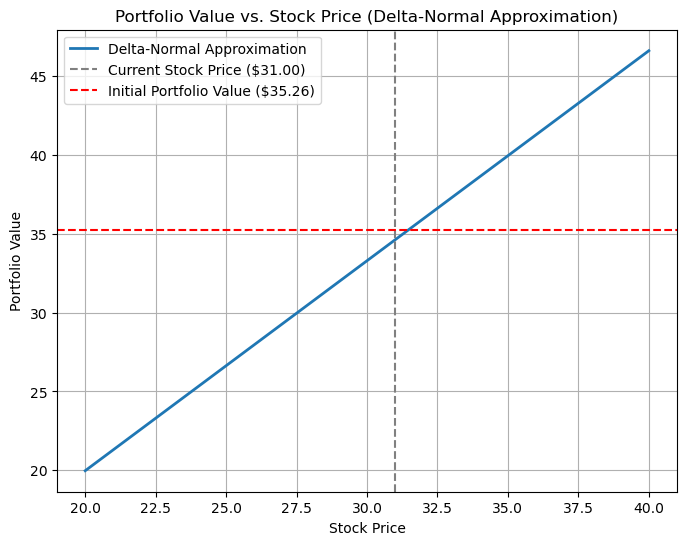

In [19]:
S_range = np.linspace(20, 40, 200)
portfolio_values = portfolio_initial + portfolio_delta * (S_range - S) + portfolio_theta * dt

# Plot the Delta-Normal approximation line
plt.figure(figsize=(8, 6))
plt.plot(S_range, portfolio_values, label="Delta-Normal Approximation", lw=2)
plt.axvline(S, color='gray', linestyle='--', label=f"Current Stock Price (${S:.2f})")
plt.axhline(portfolio_initial, color='red', linestyle='--', label=f"Initial Portfolio Value (${portfolio_initial:.2f})")
plt.xlabel("Stock Price")
plt.ylabel("Portfolio Value")
plt.title("Portfolio Value vs. Stock Price (Delta-Normal Approximation)")
plt.legend()
plt.grid(True)

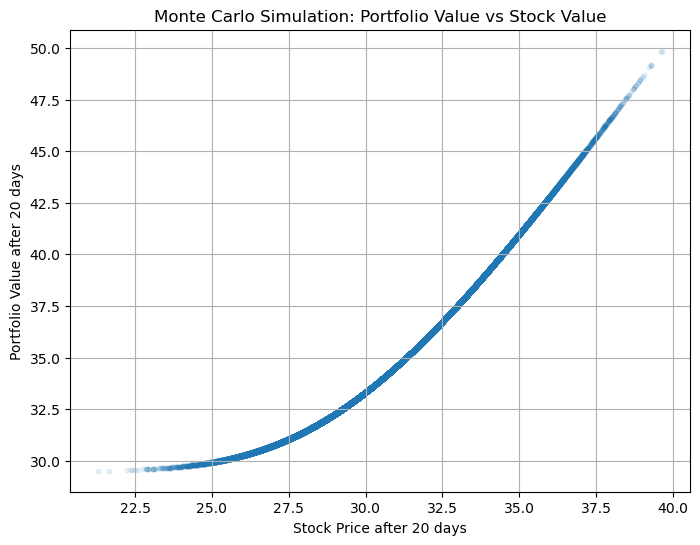

In [20]:

plt.figure(figsize=(8,6))
plt.scatter(S_sim, portfolio_sim, alpha=0.1, s=10)
plt.xlabel("Stock Price after 20 days")
plt.ylabel("Portfolio Value after 20 days")
plt.title("Monte Carlo Simulation: Portfolio Value vs Stock Value")
plt.grid(True)
plt.show()